In [224]:
## Setup dependencies
#%matplotlib inline
%matplotlib widget
from matplotlib import style
style.use('fivethirtyeight')

#To allow multiple screen outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

## Pretty print
from pprint import pprint

In [225]:
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt

# Reflect Tables into SQLAlchemy ORM

In [226]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, text

In [227]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [228]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(autoload_with=engine)

In [229]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [230]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [231]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [232]:
# Find the most recent date in the data set.
recent_date = session.query(measurement).order_by(measurement.date.desc()).first().date
recent_date

'2017-08-23'

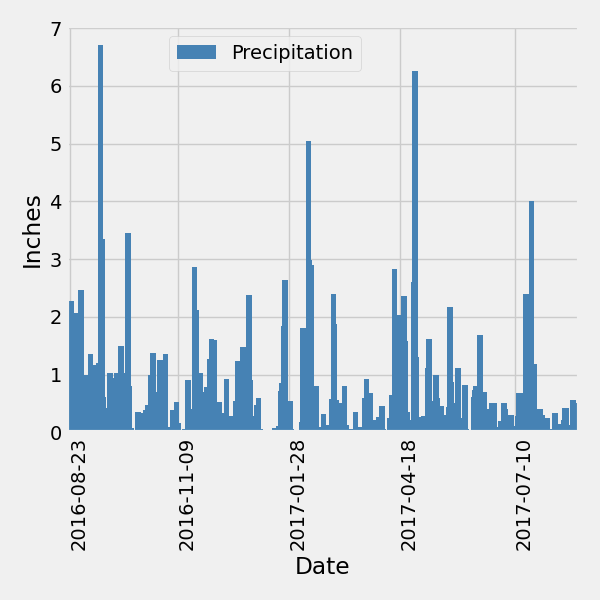

In [233]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
most_recent_date = dt.datetime.strptime(recent_date, "%Y-%m-%d").date()
one_year_ago = most_recent_date - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
one_year_query = session.query(measurement.date.desc(), measurement.prcp).\
                     filter(measurement.date >= one_year_ago).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
one_year_df = pd.DataFrame(one_year_query, columns=['Date','Precipitation'])

# Sort the dataframe by date +(& precipitation)
one_year_df = one_year_df.sort_values(by = ['Date','Precipitation'])
one_year_df = one_year_df.reset_index(drop=True)

#--------------------------------------------------------------------------
# Use Pandas Plotting with Matplotlib to plot the data

## Minimize data set to maximum values per date for plotting
one_year_df_max = one_year_df.copy()
one_year_df_max['Precipitation'] = one_year_df_max.groupby('Date')['Precipitation'].\
                                                   transform('max')
one_year_df_max = one_year_df_max.drop_duplicates()

## Configure plot, figsize, title, and axis labels
figure1 = one_year_df_max.plot(kind="bar", 
                               color="steelblue", 
                               figsize=(6,6), 
                               width=4.0,
                               xlabel="Date",
                               ylabel="Inches")

# Configure x-ticks & rotation, legend placement
xticklabels = ['2016-08-23',
               '2016-11-09',
               '2017-01-28',
               '2017-04-18',
               '2017-07-10']
figure1.set_xticks([0,78,158,238,321])
figure1.set_xticklabels(xticklabels, rotation=90, rotation_mode="anchor", ha="right", wrap=True)
plt.legend(loc = (0.2, 0.89))

# Show plot
plt.tight_layout()
plt.show();

In [234]:
# Use Pandas to calculate the summary statistics for the precipitation data
one_year_df.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [235]:
# Design a query to calculate the total number of stations in the dataset
with engine.connect() as conn:
    print(conn.execute(text('SELECT count(distinct measurement.station) FROM measurement LIMIT 5')).fetchall())

##Alternative method
num_stations = session.query(measurement.station).distinct().count()
num_stations

[(9,)]


9

In [236]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
active_stations = session.query(measurement.station, 
                                func.count(measurement.station)).\
                          group_by(measurement.station).\
                          order_by(func.count(measurement.station).desc()).\
                          all()
active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [237]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station = active_stations[0][0]

session.query(func.min(measurement.tobs),
              func.max(measurement.tobs),
              func.avg(measurement.tobs)).\
        filter(measurement.station == most_active_station).\
        all()

[(54.0, 85.0, 71.66378066378067)]

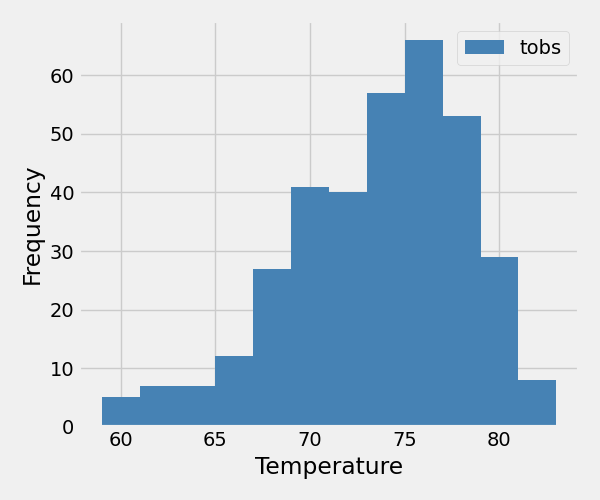

In [238]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
last_twelve = session.query(measurement.date, measurement.tobs).\
                      filter(measurement.date >= one_year_ago).\
                      filter(measurement.station == most_active_station).\
                      order_by(measurement.date).\
                      all()

## Configure DF, plot, figsize, title, and axis labels
last_12_df = pd.DataFrame(last_twelve)
last_12_df


figure1 = last_12_df.plot(kind="hist", 
                          color="steelblue", 
                          figsize=(6,5), 
                          width=2.0, 
                          bins = 12,
                          xlabel="Temperature",
                          ylabel="Frequency")
plt.tight_layout()
plt.show();

# Close Session

In [239]:
# Close Session
session.close()